In [ ]:
pip install insightface onnxruntime-gpu onnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/439.5 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 17.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp311-cp311-linux_x86_64.whl size=1064923 sha256=57571b24ca11c3947e8958019341e0f76073f75d71f9aeda0da83bfe15975b1d
  Stored in directory: /root/.cache/pip/wheels/27/d8/22/f52d858d16cd06e7b2e6aad34a1777dcfaf000be833bbf8146
Successfully built insightface


In [ ]:
pip install opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
import pickle
import albumentations as A
from albumentations.pytorch import ToTensorV2
from insightface.app import FaceAnalysis
import joblib  # For saving/loading embeddings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cupy as cp
from collections import defaultdict
import random

# Feature Extraction

In [ ]:
# Initialize ArcFace feature extractor
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0)  # ctx_id=0 for CPU, change to GPU if available

# Augmentation Pipeline (for training data only)
augmentor = A.Compose([
    A.HorizontalFlip(p=0.3),  # safer to lower flip chance
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.3),  # milder shifts
    A.GaussianBlur(blur_limit=1, p=0.1),  # very light blur
    ToTensorV2()
])


# Preprocessing Functions
def apply_clahe(img):
    """Apply CLAHE to enhance contrast under poor lighting."""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def gamma_correction(img, gamma=1.2):
    """Adjust image brightness adaptively."""
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

def preprocess_image(img):
    """Apply both CLAHE and Gamma Correction."""
    img = apply_clahe(img)
    img = gamma_correction(img, gamma=1.2)
    return img

#  Function to extract face embeddings
def extract_embedding(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Unable to load '{image_path}'")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)  # Apply lighting correction

    # Detect faces
    faces = app.get(img)
    if len(faces) == 0:
        print(f"⚠️ No face detected in '{image_path}'")
        return None

    return faces[0].embedding  # Return embedding of the first detected face

#  Function to apply augmentation
def augment_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Unable to load '{image_path}'")
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    augmented = augmentor(image=img)
    aug_img = augmented["image"].permute(1, 2, 0).numpy().astype(np.float32)

    return aug_img

#  Function to load dataset paths with per-person splitting
def get_dataset_paths_per_person(dataset_path, train_size=10, test_size=2):
    image_paths = defaultdict(list)

    for person_name in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_path) or person_name.startswith('.'):
            continue

        images = [os.path.join(person_path, img) for img in os.listdir(person_path)]
        if len(images) < (train_size + test_size):  # Ensure enough images
            continue

        random.shuffle(images)  # Shuffle to avoid bias
        image_paths[person_name] = images  # Store images per person

    train_paths, test_paths, train_labels, test_labels = [], [], [], []

    for person, images in image_paths.items():
        train_paths.extend(images[:train_size])  # First 10 images for training
        test_paths.extend(images[train_size:train_size + test_size])  # Next 2 for testing
        train_labels.extend([person] * train_size)
        test_labels.extend([person] * test_size)

    return train_paths, test_paths, train_labels, test_labels

#  Function to generate embeddings (train with augmentation)
def generate_embeddings(image_paths, labels, augment=False):
    X, y = [], []

    for idx, img_path in enumerate(image_paths):
        embeddings = []

        # Extract original embedding
        embedding = extract_embedding(img_path)
        if embedding is not None:
            embeddings.append(embedding)

        if augment:
            for i in range(5):  # Generate 5 augmented versions
                aug_img = augment_image(img_path)
                if aug_img is not None:
                    faces_aug = app.get(aug_img)
                    if len(faces_aug) > 0:
                        embeddings.append(faces_aug[0].embedding)
                    else:
                        print(f"[Augmentation {i+1}] ❌ No face detected in augmented image: {img_path}")
                else:
                    print(f"[Augmentation {i+1}] ⚠️ Augmentation returned None for: {img_path}")

        # Store embeddings and labels
        X.extend(embeddings)
        y.extend([labels[idx]] * len(embeddings))  # Match label count

    return np.array(X), np.array(y)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

In [ ]:
#  Load dataset path
dataset_path = r'/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled'

#  Get image paths per person (10 train, 2 test per person)
train_paths, test_paths, train_labels, test_labels = get_dataset_paths_per_person(dataset_path)

print(f"✅ Training Images: {len(train_paths)}, Testing Images: {len(test_paths)}")

#  Generate embeddings
X_train, y_train = generate_embeddings(train_paths, train_labels, augment=True)
X_test, y_test = generate_embeddings(test_paths, test_labels, augment=False)

#  Save embeddings
embedding_file = "illumination_arc_face_embeddings.pkl"
with open(embedding_file, "wb") as f:
    pickle.dump({"X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}, f)

print(f"✅ Embeddings saved to {embedding_file}")






✅ Training Images: 1280, Testing Images: 256
⚠️ No face detected in '/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Pierce_Brosnan/Pierce_Brosnan_0001.jpg'
[Augmentation 5] ❌ No face detected in augmented image: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Pierce_Brosnan/Pierce_Brosnan_0001.jpg
⚠️ No face detected in '/content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Richard_Myers/Richard_Myers_0003.jpg'
[Augmentation 1] ❌ No face detected in augmented image: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Richard_Myers/Richard_Myers_0003.jpg
[Augmentation 2] ❌ No face detected in augmented image: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Richard_Myers/Richard_Myers_0003.jpg
[Augmentation 3] ❌ No face detected in augmented image: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/Richard_Myers/Richard_Myers_0003.jpg
[Augmentation 4] ❌ No face detected in augmented image: /content/drive/MyDrive/lfw-deepfunneled/lfw-deepfunneled/

# Classifier

In [5]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# ✅ Load embeddings
with open("illumination_arc_face_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

In [6]:

# Load embeddings
def load_embeddings(file_path):
    
    with open(file_path, "rb") as f:
        data = pickle.load(f)

    return data



# Evaluate the classifier
def evaluate_classifier(classifier, X_test, y_test):
   
    # Make predictions
    y_pred = classifier.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate detailed classification report
    report = classification_report(y_test, y_pred)

    # Get the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, report, conf_matrix, y_pred

# Function to predict identity with confidence score
def predict_with_confidence(classifier, face_embedding, classifier_type='knn'):
   
    # Reshape if single embedding
    if face_embedding.ndim == 1:
        face_embedding = face_embedding.reshape(1, -1)

    # Get the predicted class
    predicted_identity = classifier.predict(face_embedding)[0]

    # Calculate confidence based on classifier type
    if classifier_type == 'knn':
        # For KNN, use distance to neighbors
        distances, indices = classifier.kneighbors(face_embedding)

        if classifier.metric == 'cosine':
            # For cosine distance, convert to similarity
            confidence = 1 - distances.mean()
        else:
            # For other metrics, normalize
            max_dist = np.sqrt(2) if classifier.metric == 'euclidean' else 1
            confidence = 1 - (distances.mean() / max_dist)

    elif classifier_type in ['svm', 'rf', 'lr']:
        # For other classifiers, use prediction probability
        if hasattr(classifier, 'predict_proba'):
            # Get probability of the predicted class
            proba = classifier.predict_proba(face_embedding)[0]
            # Get the index of the predicted class
            class_idx = np.where(classifier.classes_ == predicted_identity)[0][0]
            # Get the probability score for the predicted class
            confidence = proba[class_idx]
        else:
            # If predict_proba is not available, use decision_function if possible
            if hasattr(classifier, 'decision_function'):
                # Get decision values
                decision_values = classifier.decision_function(face_embedding)[0]
                # Normalize to [0,1] using softmax
                exp_values = np.exp(decision_values - np.max(decision_values))
                confidence = exp_values / exp_values.sum()

                # If multi-class, find the confidence for the predicted class
                if len(decision_values) > 1:
                    class_idx = np.where(classifier.classes_ == predicted_identity)[0][0]
                    confidence = confidence[class_idx]
                else:
                    # For binary classification
                    confidence = confidence[0] if predicted_identity == classifier.classes_[1] else 1 - confidence[0]
            else:
                # If no confidence measure is available, use a default value
                confidence = 0.5

    else:
        raise ValueError(f"Unsupported classifier type for confidence calculation: {classifier_type}")

    return predicted_identity, float(confidence)

# Function to recognize a face in a new image
def recognize_face(image_path, classifier, extract_embedding_func, classifier_type='knn', confidence_threshold=0.6):

    # Extract face embedding
    embedding = extract_embedding_func(image_path)

    if embedding is None:
        return "No face detected", 0.0

    # Predict identity with confidence
    identity, confidence = predict_with_confidence(classifier, embedding, classifier_type)

    # Return unknown if confidence is below threshold
    if confidence < confidence_threshold:
        return "Unknown", confidence

    return identity, confidence

# Save the trained classifier
def save_classifier(classifier, file_path):
    """
    Save the trained classifier to disk

    Parameters:
        classifier: Trained classifier
        file_path: Path where to save the classifier
    """
    joblib.dump(classifier, file_path)
    print(f"✅ Classifier saved to {file_path}")

# Load a saved classifier
def load_classifier(file_path):
    """
    Load a saved classifier from disk

    Parameters:
        file_path: Path to the saved classifier

    Returns:
        Loaded classifier
    """
    return joblib.dump(file_path)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def run_cross_validation(classifier, X_train, y_train, k_folds=5):
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []

    print(f"\n📊 {type(classifier).__name__.upper()} {k_folds}-Fold Cross-Validation:")

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        # Clone and train the classifier
        fold_classifier = classifier
        fold_classifier.fit(X_fold_train, y_fold_train)

        # Make predictions
        y_fold_pred = fold_classifier.predict(X_fold_val)

        # Calculate accuracy
        fold_accuracy = accuracy_score(y_fold_val, y_fold_pred)
        fold_accuracies.append(fold_accuracy)

        all_y_true.extend(y_fold_val)
        all_y_pred.extend(y_fold_pred)

        print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")

    # Aggregate results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)

    print("\n=== Cross-Validation Summary ===")
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation: {std_accuracy:.4f}")

    # Classification report
    print("\n=== Aggregate Classification Report ===")
    print(classification_report(all_y_true, all_y_pred))

    return mean_accuracy, std_accuracy, all_y_true, all_y_pred


# SVC

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import time
start_time = time.time()

classifier = SVC(C=1.0, kernel='rbf', probability=True)
classifier.fit(X_train, y_train)
classifier_type = "svm"

# Prediction Code
end_time = time.time()
print(f"Training Time: {end_time - start_time} seconds")

# Evaluate on test data
print(f"📊 Evaluating {classifier_type.upper()} Classifier...")
accuracy, report, conf_matrix, y_pred = evaluate_classifier(classifier, X_test, y_test)

# Print results
print(f"\n✅ {classifier_type.upper()} Classifier Accuracy: {accuracy:.4f}")
print("\n✅ Classification Report:")
print(report)

# Demonstrate prediction with confidence on a few examples
print("\n📊 Example Predictions with Confidence:")
for i in range(min(5, len(X_test))):
    identity, confidence = predict_with_confidence(classifier, X_test[i], classifier_type)
    print(f"  Sample {i+1}: Predicted as '{identity}' with {confidence:.4f} confidence " +
              f"(True identity: '{y_test[i]}', {'✓' if identity == y_test[i] else '✗'})")

# Save the trained classifier
model_file = f"face_recognition_{classifier_type}_model.joblib"
save_classifier(classifier, model_file)


Training Time: 8.871662378311157 seconds
📊 Evaluating SVM Classifier...

✅ SVM Classifier Accuracy: 0.9844

✅ Classification Report:
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         2
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      1.00      1.00         2
             Alvaro_Uribe       1.00      1.00      1.00         2
          Amelie_Mauresmo       1.00      1.00      1.00         2
             Andre_Agassi       1.00      1.00      1.00         2
             Andy_Roddick       1.00      1.00      1.00         2
           Angelina_Jolie       1.00      1.00      1.00         2
          Anna_Kournikova       0.67      1.00      0.80         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      1.00      1.00         2
    Arnold_Schwarzenegger       1.00      1.00      1.00      

In [ ]:
import joblib

# Load classifier from file
classifier = joblib.load('/content/drive/MyDrive/face_recognition_svm_model.joblib')

mean_acc, std_acc, y_true, y_pred = run_cross_validation(classifier, X_train, y_train)


📊 SVC 5-Fold Cross-Validation:
Fold 1 Accuracy: 0.9941
Fold 2 Accuracy: 0.9980
Fold 3 Accuracy: 0.9882
Fold 4 Accuracy: 0.9882
Fold 5 Accuracy: 0.9941

=== Cross-Validation Summary ===
Mean Accuracy: 0.9925
Standard Deviation: 0.0038

=== Aggregate Classification Report ===
                           precision    recall  f1-score   support

             Abdullah_Gul       0.91      1.00      0.95        20
             Adrien_Brody       1.00      1.00      1.00        20
         Alejandro_Toledo       1.00      1.00      1.00        20
             Alvaro_Uribe       1.00      1.00      1.00        20
          Amelie_Mauresmo       1.00      1.00      1.00        20
             Andre_Agassi       1.00      1.00      1.00        20
             Andy_Roddick       1.00      1.00      1.00        20
           Angelina_Jolie       1.00      1.00      1.00        20
          Anna_Kournikova       0.74      1.00      0.85        20
            Ari_Fleischer       1.00      1.00      1

## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import time
start_time = time.time()

classifier = knn = KNeighborsClassifier(n_neighbors=9, metric='cosine', weights='distance')
classifier.fit(X_train, y_train)
classifier_type = "knn"

# Prediction Code
end_time = time.time()
print(f"Training Time: {end_time - start_time} seconds")

# Evaluate on test data
print(f"📊 Evaluating {classifier_type.upper()} Classifier...")
accuracy, report, conf_matrix, y_pred = evaluate_classifier(classifier, X_test, y_test)

# Print results
print(f"\n✅ {classifier_type.upper()} Classifier Accuracy: {accuracy:.4f}")
print("\n✅ Classification Report:")
print(report)

# Demonstrate prediction with confidence on a few examples
print("\n📊 Example Predictions with Confidence:")
for i in range(min(5, len(X_test))):
    identity, confidence = predict_with_confidence(classifier, X_test[i], classifier_type)
    print(f"  Sample {i+1}: Predicted as '{identity}' with {confidence:.4f} confidence " +
              f"(True identity: '{y_test[i]}', {'✓' if identity == y_test[i] else '✗'})")

# Save the trained classifier
model_file = f"face_recognition_{classifier_type}_model.joblib"
save_classifier(classifier, model_file)


Training Time: 0.005006074905395508 seconds
📊 Evaluating KNN Classifier...

✅ KNN Classifier Accuracy: 0.9883

✅ Classification Report:
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         2
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      1.00      1.00         2
             Alvaro_Uribe       1.00      1.00      1.00         2
          Amelie_Mauresmo       1.00      1.00      1.00         2
             Andre_Agassi       1.00      1.00      1.00         2
             Andy_Roddick       1.00      1.00      1.00         2
           Angelina_Jolie       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      1.00      1.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      1.00      1.00         2
    Arnold_Schwarzenegger       1.00      1.00      1.00   

NameError: name 'ConfusionMatrixDisplay' is not defined

In [31]:
import joblib

# Load classifier from file
classifier = joblib.load('face_recognition_knn_model.joblib')

mean_acc, std_acc, y_true, y_pred = run_cross_validation(classifier, X_train, y_train)


📊 KNEIGHBORSCLASSIFIER 5-Fold Cross-Validation:
Fold 1 Accuracy: 0.9961
Fold 2 Accuracy: 0.9961
Fold 3 Accuracy: 0.9941
Fold 4 Accuracy: 0.9902
Fold 5 Accuracy: 0.9961

=== Cross-Validation Summary ===
Mean Accuracy: 0.9945
Standard Deviation: 0.0023

=== Aggregate Classification Report ===
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00        20
             Adrien_Brody       1.00      1.00      1.00        20
         Alejandro_Toledo       1.00      1.00      1.00        20
             Alvaro_Uribe       1.00      1.00      1.00        20
          Amelie_Mauresmo       1.00      1.00      1.00        20
             Andre_Agassi       1.00      1.00      1.00        20
             Andy_Roddick       1.00      1.00      1.00        20
           Angelina_Jolie       1.00      1.00      1.00        20
          Anna_Kournikova       1.00      1.00      1.00        20
            Ari_Fleischer       1.00

## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
import time
start_time = time.time()

classifier = RandomForestClassifier(n_estimators=1000, max_depth=10)
classifier.fit(X_train, y_train)
classifier_type = "rf"

# Prediction Code
end_time = time.time()
print(f"Training Time: {end_time - start_time} seconds")

# Evaluate on test data
print(f"📊 Evaluating {classifier_type.upper()} Classifier...")
accuracy, report, conf_matrix, y_pred = evaluate_classifier(classifier, X_test, y_test)

# Print results
print(f"\n✅ {classifier_type.upper()} Classifier Accuracy: {accuracy:.4f}")
print("\n✅ Classification Report:")
print(report)

# Demonstrate prediction with confidence on a few examples
print("\n📊 Example Predictions with Confidence:")
for i in range(min(5, len(X_test))):
    identity, confidence = predict_with_confidence(classifier, X_test[i], classifier_type)
    print(f"  Sample {i+1}: Predicted as '{identity}' with {confidence:.4f} confidence " +
              f"(True identity: '{y_test[i]}', {'✓' if identity == y_test[i] else '✗'})")

# Save the trained classifier
model_file = f"face_recognition_{classifier_type}_model.joblib"
save_classifier(classifier, model_file)

Training Time: 160.84958577156067 seconds
📊 Evaluating RF Classifier...

✅ RF Classifier Accuracy: 0.9336

✅ Classification Report:
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         2
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      1.00      1.00         2
             Alvaro_Uribe       1.00      1.00      1.00         2
          Amelie_Mauresmo       0.67      1.00      0.80         2
             Andre_Agassi       1.00      1.00      1.00         2
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         2
          Anna_Kournikova       0.67      1.00      0.80         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      1.00      1.00         2
    Arnold_Schwarzenegger       1.00      1.00      1.00       

C:\Users\User\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Sample 1: Predicted as 'Trent_Lott' with 0.0480 confidence (True identity: 'Trent_Lott', ✓)
  Sample 2: Predicted as 'Trent_Lott' with 0.0334 confidence (True identity: 'Trent_Lott', ✓)
  Sample 3: Predicted as 'Wen_Jiabao' with 0.0839 confidence (True identity: 'Wen_Jiabao', ✓)
  Sample 4: Predicted as 'Wen_Jiabao' with 0.0880 confidence (True identity: 'Wen_Jiabao', ✓)
  Sample 5: Predicted as 'Venus_Williams' with 0.0301 confidence (True identity: 'Venus_Williams', ✓)
✅ Classifier saved to face_recognition_rf_model.joblib


In [20]:
print(f"Prediction Time: {end_time - start_time} seconds")

Prediction Time: 138.62602257728577 seconds


In [ ]:
import joblib

# Load classifier from file
classifier = joblib.load('/content/drive/MyDrive/face_recognition_rf_model.joblib')

mean_acc, std_acc, y_true, y_pred = run_cross_validation(classifier, X_train, y_train)


📊 RANDOMFORESTCLASSIFIER 5-Fold Cross-Validation:
Fold 1 Accuracy: 0.9333
Fold 2 Accuracy: 0.9627
Fold 3 Accuracy: 0.9490
Fold 4 Accuracy: 0.9549
Fold 5 Accuracy: 0.9705

=== Cross-Validation Summary ===
Mean Accuracy: 0.9541
Standard Deviation: 0.0127

=== Aggregate Classification Report ===
                           precision    recall  f1-score   support

             Abdullah_Gul       0.91      1.00      0.95        20
             Adrien_Brody       0.95      1.00      0.98        20
         Alejandro_Toledo       1.00      0.95      0.97        20
             Alvaro_Uribe       0.95      0.95      0.95        20
          Amelie_Mauresmo       1.00      1.00      1.00        20
             Andre_Agassi       1.00      1.00      1.00        20
             Andy_Roddick       1.00      0.70      0.82        20
           Angelina_Jolie       1.00      1.00      1.00        20
          Anna_Kournikova       1.00      0.80      0.89        20
            Ari_Fleischer       0.

# AUC Score evaluation

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from joblib import load
import numpy as np

# Binarize labels for multiclass AUC calculation
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))

# Load trained classifiers
rf = load('face_recognition_rf_model.joblib')
knn = load('face_recognition_knn_model.joblib')
svm = load('face_recognition_svm_model.joblib')

# Define classifiers with names
classifiers = {
    "Random Forest": rf,
    "KNN": knn,
    "SVM (RBF)": svm
}

# Dictionary to store AUC scores
auc_scores = {}

# Predict and calculate macro AUC for each classifier
for name, clf in classifiers.items():
    y_pred_prob = clf.predict_proba(X_test)
    
    # Compute macro-averaged AUC
    macro_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
    auc_scores[name] = macro_auc

# Print results
print("📊 Macro-Averaged AUC Scores:")
for name, score in auc_scores.items():
    print(f"{name}: {score:.4f}")

📊 Macro-Averaged AUC Scores:
Random Forest: 0.9934
KNN: 0.9941
SVM (RBF): 0.9977


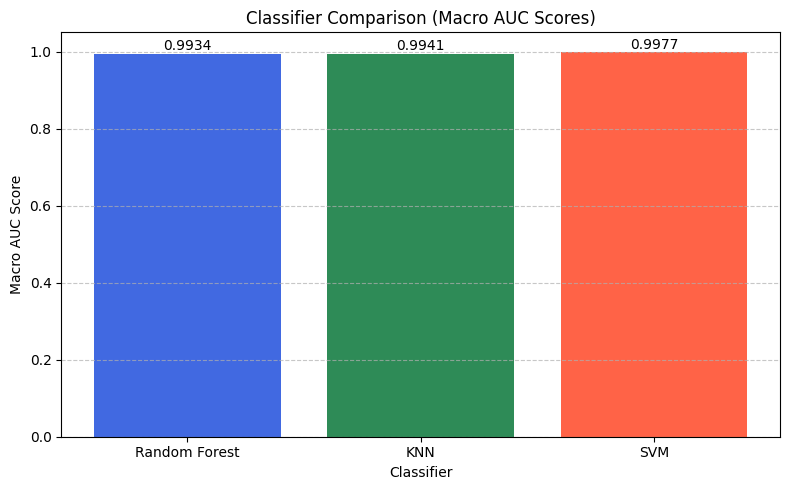

In [12]:
import matplotlib.pyplot as plt

# Example AUC scores dictionary
auc_scores = {
    'Random Forest': 0.9934,
    'KNN': 0.9941,
    'SVM': 0.9977
}

# Extract keys and values
classifiers = list(auc_scores.keys())
scores = list(auc_scores.values())

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(classifiers, scores, color=['royalblue', 'seagreen', 'tomato'])

# Add labels and title
plt.ylabel('Macro AUC Score')
plt.xlabel('Classifier')
plt.title('Classifier Comparison (Macro AUC Scores)')
plt.ylim(0, 1.05)

# Add score values on top of bars
for i, v in enumerate(scores):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Top-N Accuracy Chart

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.4.2. This might lead to breaki

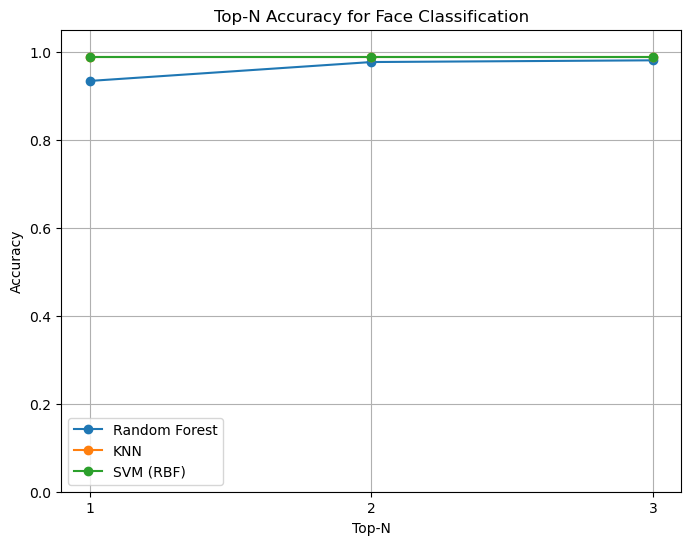

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
from joblib import load

# Load your trained models
rf = load('face_recognition_rf_model.joblib')
knn = load('face_recognition_knn_model.joblib')
svm = load('face_recognition_svm_model.joblib')

# Define your classifiers
classifiers = {
    "Random Forest": rf,
    "KNN": knn,
    "SVM (RBF)": svm
}

# Number of top predictions to test
top_n_values = [1, 2, 3]

# Dictionary to store Top-N accuracy for each classifier
top_n_accuracies = {}

# Calculate Top-N accuracy for each classifier
for name, clf in classifiers.items():
    y_pred_proba = clf.predict_proba(X_test)
    scores = []
    
    for n in top_n_values:
        score = top_k_accuracy_score(y_test, y_pred_proba, k=n, labels=np.unique(y_train))
        scores.append(score)
    
    top_n_accuracies[name] = scores

# Plotting the Top-N accuracy
plt.figure(figsize=(8, 6))
for name, scores in top_n_accuracies.items():
    plt.plot(top_n_values, scores, marker='o', label=f"{name}")

plt.title("Top-N Accuracy for Face Classification")
plt.xlabel("Top-N")
plt.ylabel("Accuracy")
plt.xticks(top_n_values)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


# Frame Per Second

In [8]:
import cv2
import numpy as np
import pickle
from insightface.app import FaceAnalysis

#  Load saved embeddings
embedding_file = r"C:/Users/User/OneDrive/Documents/FYP/main_system/my-app/server/illumination_arc_face_embeddings.pkl"
with open(embedding_file, "rb") as f:
    data = pickle.load(f)
    X_train, y_train = data["X_train"], data["y_train"]

#  Initialize ArcFace feature extractor
app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0)  # ctx_id=0 for CPU, change to GPU if available

#  Preprocessing Functions
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

def gamma_correction(img, gamma=1.2):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

def preprocess_image(img):
    img = apply_clahe(img)
    img = gamma_correction(img, gamma=1.2)
    return img

#  Face Recognition using KNN
def predict_image(embedding,classifier, threshold=0.7):
    probabilities = classifier.predict_proba([embedding])[0]
    max_prob = max(probabilities)
    predicted_label = classifier.classes_[np.argmax(probabilities)]

    if max_prob >= threshold:
        return predicted_label, max_prob * 100
    else:
        return "Unknown", max_prob * 100

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\User/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127

# KNN Live Cam

In [24]:
import joblib
import time  # 
from joblib import load

# ✅ Load the trained KNN model
classifier = load('face_recognition_knn_model.joblib')

# ✅ Start Live Webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

start_time = time.time()  # ⏱ Start timing the session
frame_count = 0  # 🧮 Initialize frame counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1  #
    
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_rgb = preprocess_image(img_rgb)  # Apply CLAHE & Gamma Correction
    
    faces = app.get(img_rgb)

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        label, confidence = predict_image(embedding,classifier)
        text = f"{label} ({confidence:.2f}%)"

        # Draw bounding box and label
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(frame, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    cv2.imshow("KNN Live Face Recognition", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

end_time = time.time()
total_time = end_time - start_time
average_fps = frame_count / total_time
print(f"\n✅ Average FPS during session: {average_fps:.2f}")

C:\Users\User\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



✅ Average FPS during session: 2.29


# SVM Live Cam

In [22]:
import joblib
import time  # 
from joblib import load

# ✅ Load the trained KNN model
classifier = load('face_recognition_svm_model.joblib')

# ✅ Start Live Webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

start_time = time.time()  # ⏱ Start timing the session
frame_count = 0  # 🧮 Initialize frame counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1  #
    
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_rgb = preprocess_image(img_rgb)  # Apply CLAHE & Gamma Correction
    
    faces = app.get(img_rgb)

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        label, confidence = predict_image(embedding,classifier)
        text = f"{label} ({confidence:.2f}%)"

        # Draw bounding box and label
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(frame, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    cv2.imshow("Support Vector Machine Live Face Recognition", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

end_time = time.time()
total_time = end_time - start_time
average_fps = frame_count / total_time
print(f"\n✅ Average FPS during session: {average_fps:.2f}")


✅ Average FPS during session: 2.72


# Random Forest Live Cam

In [20]:
import joblib
import time  # 
from joblib import load

# ✅ Load the trained KNN model
classifier = load('face_recognition_rf_model.joblib')

# ✅ Start Live Webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

start_time = time.time()  # ⏱ Start timing the session
frame_count = 0  # 🧮 Initialize frame counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1  #
    
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_rgb = preprocess_image(img_rgb)  # Apply CLAHE & Gamma Correction
    
    faces = app.get(img_rgb)

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        label, confidence = predict_image(embedding,classifier)
        text = f"{label} ({confidence:.2f}%)"

        # Draw bounding box and label
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(frame, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    cv2.imshow("Random Forest Live Face Recognition", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

end_time = time.time()
total_time = end_time - start_time
average_fps = frame_count / total_time
print(f"\n✅ Average FPS during session: {average_fps:.2f}")


✅ Average FPS during session: 2.21


# KNN Live Cam without preprocessing

In [25]:
import joblib
import time  # 
from joblib import load

# ✅ Load the trained KNN model
classifier = load('face_recognition_knn_model.joblib')

# ✅ Start Live Webcam
cap = cv2.VideoCapture(0)  # 0 for default webcam

start_time = time.time()  # ⏱ Start timing the session
frame_count = 0  # 🧮 Initialize frame counter

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1  #
    
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    faces = app.get(img_rgb)

    for face in faces:
        bbox = face.bbox.astype(int)
        embedding = face.embedding

        label, confidence = predict_image(embedding,classifier)
        text = f"{label} ({confidence:.2f}%)"

        # Draw bounding box and label
        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)
        cv2.putText(frame, text, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time
    cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    cv2.imshow("KNN Live Face Recognition", frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

end_time = time.time()
total_time = end_time - start_time
average_fps = frame_count / total_time
print(f"\n✅ Average FPS during session: {average_fps:.2f}")

C:\Users\User\anaconda3\envs\py310\lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



✅ Average FPS during session: 6.08
